<h1><center>Тема 10. Жадный алгоритм построения композиции алгоритмов</center></h1>

<a class="anchor" id="10"></a>

## Содержание

1. [Бустинг, градиентный бустинг и XGBoost](#10.1)
    - [Алгоритм AdaBoost](#10.1.1)
    - [Градиентный бустинг](#10.1.2)
    - [Алгоритм XGBoost](#10.1.3)
2. [Сравнение XGBoost и градиентного бустинга Sklearn](#10.2)
    - [Стационарность, единичные корни](#10.2.1)
    - [Сравнение алгоритмов по времени работы](#10.2.2)
3. [Линейные и не очень модели на временных рядах](#10.3)
    - [Линейная регрессия vs XGBoost](#10.3.1)
    - [Инициализация параметров](#10.3.2)
    - [Обучение классификатора](#10.3.3)
4. [XGBoost, интерфейс Sklearn](#10.4)
5. [Оценка важности признаков с XGBoost](#10.5)
6. [Борьба с недообучением и переобучением XGBoost](#10.6)
7. [XGBoost и Hyperopt в соревновании Kaggle Forest Cover Type Prediction](#10.7)
8. [Оценка результатов XGBoost](#10.8)
9. [XGBoost и несбалансированные выборки](#10.9)
10. [Продвинутые методы работы с категориальными признаками и CatBoost](#10.10)
11. [Заключение](#conclusion10)
12. [Полезные ссылки](#reference10)

<a class="anchor" id="10.1"></a>

## 10.1. Бустинг, градиентный бустинг и XGBoost

[Вернуться к содержанию](#10)

Бустинг представляет собой жадный алгоритм построения композиции алгоритмов. Основная идея заключается в том, чтобы, имея множество относительно слабых алгоритмов обучения, построить их хорошую линейную комбинацию. Он похож на бэггинг тем, что базовый алгоритм обучения фиксирован. Отличие состоит в том, что обучение базовых алгоритмов для композиции происходит итеративно, и каждый следующий алгоритм стремится компенсировать недостатки композиции всех предыдущих алгоритмов.

На примере бустинга стало ясно, что хорошим качеством могут обладать сколь угодно сложные композиции классификаторов, при условии, что они правильно настраиваются. Это развеяло существовавшие долгое время представления о том, что для повышения обобщающей способности необходимо ограничивать сложность алгоритмов. 

Впоследствии этот феномен бустинга получил теоретическое обоснование. Оказалось, что взвешенное голосование не увеличивает эффективную сложность алгоритма, а лишь сглаживает ответы базовых алгоритмов. Эффективность бустинга объясняется тем, что по мере добавления базовых алгоритмов увеличиваются отступы обучающих объектов. Причём бустинг продолжает раздвигать классы даже после достижения безошибочной классификации обучающей выборки.

Общая схема бустинга:
- Искомый ансамбль алгоритмов имеет вид $a(x) = \mbox{sign}(\sum_{t = 1}^T \alpha_t b_t(x))$, где $b_t$ - базовые алгоритмы.
- Ансамбль строится итеративно, оптимизируя на каждом шаге функционал $Q_t$, равный количеству ошибок текущей композиции на обучающей выборке.
- При добавлении слагаемого $\alpha_t b_t(x)$ в сумму, функционал $Q_t$ оптимизируется только по базовому алгоритму $b_t(x)$ и коэффициенту $\alpha_t$ при нём, все предыдущие слагаемые считаются фиксированными.
- Функционал $Q_t$ имеет вид суммы по объектам обучающей выборки пороговых функций вида $[y_i \sum_{j = 1}^t \alpha_j b_j(x_i) < 0]$, имеющих смысл "текущая композиция ошибается на объекте с номером $i$". Каждое такое слагаемое имеет вид "ступеньки" и является разрывной функцией. Для упрощения решения задачи оптимизации такая пороговая функция заменяется на непрерывно дифференцируемую оценку сверху. В итоге получается новый функционал $\hat{Q}_t \geqslant Q_t$, минимизация которого приводит к минимизации исходного функционала $Q_t$.

Используя различные аппроксимации для пороговой функции потерь $[z < 0]$, будем получать различные виды бустинга. Примеры:
- $e^{-z}$ - AdaBoost
- $\log_2(1 + e^{-z})$ - LogitBoost
- $(1 - z)^2$ - GentleBoost
- $e^{-cz(z+a)}$ - BrownBoost
- другие

In [1]:
import numpy as np
from urllib.request import urlopen
%matplotlib inline
from matplotlib import pyplot as plt
import XGBoost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris, load_digits, load_boston

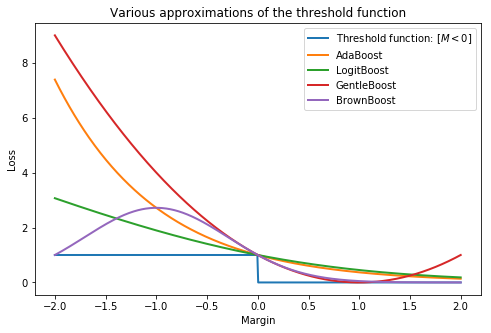

In [2]:
x = np.linspace(-2, 2, 500)

plt.figure(figsize=(8,5))
plt.plot(x, x < 0, lw=2, label='Threshold function: $[M < 0$]')
plt.plot(x, np.exp(-x), lw=2, label='AdaBoost')
plt.plot(x, np.log2(1 + np.exp(-x)), lw=2, label='LogitBoost')
plt.plot(x, (1 - x) ** 2, lw=2, label='GentleBoost')
plt.plot(x, np.exp(-x * (x + 2)), lw=2, label='BrownBoost')
plt.title('Various approximations of the threshold function')
plt.legend(loc='best')
plt.xlabel('Margin')
plt.ylabel('Loss');

<a class="anchor" id="10.1.1"></a>

### 10.1.1 Алгоритм AdaBoost

[Вернуться к содержанию](#10)

Как было сказано, алгоритм AdaBoost получается из описанной схемы, при аппроксимации пороговой функции потерь с помощью функции $e^{-z}$. Cуществует теорема (Freund, Schapire, 1996), дающая для достаточно богатых семейств базовых классификаторов явные формулы для базового алгоритма $b_t(x)$ и коэффициента $\alpha_t$ при нём, на которых достигается минимум функционала $\hat{Q}_t$. 

Сам алгоритм выглядит следующим образом:
- Инициализировать веса объектов $\Large w_i^{(0)} = \frac{1}{l}, i = 1, \dots, l$.
- Для всех $t = 1, \dots, T$
    * Обучить базовый алгоритм $\Large b_t$, пусть $\epsilon_t$ – его ошибка на обучающей выборке.
    * $\Large \alpha_t = \frac{1}{2}ln\frac{1 - \epsilon_t}{\epsilon_t}$.
    * Обновить веса объектов: $\Large w_i^{(t)} = w_i^{(t-1)} e^{-\alpha_t y_i b_t(x_i)}, i = 1, \dots, l$.
    * Нормировать веса объектов: $\Large w_0^{(t)} = \sum_{j = 1}^k w_j^{(t)}, w_i^{(t)} = \frac{w_i^{(t)}}{w_0^{(t)}}, i = 1, \dots, l$.
- Вернуть $\sum_t^{T}\alpha_tb_t$

Таким образом, вновь добавляемый алгоритм обучается путём минимизации взвешенной частоты ошибок на обучающей выборке, а не стандартного функционала, равного частоте ошибок. Вес объекта увеличивается в $e^{\alpha_t}$ раз, когда $b_t$ допускает на нём ошибку, и уменьшается во столько же раз, когда $b_t$ правильно классифицирует этот объект. Таким образом, непосредственно перед настройкой базового алгоритма наибольший вес накапливается у тех объектов, которые чаще оказывались трудными для классификации предыдущими алгоритмами.

#### Пример для иллюстрации

Пусть базовые алгоритмы – всего лишь "пеньки", то есть деревья решений глубины 1.

![image](https://raw.githubusercontent.com/soolstafir/Machine-learning-course/master/img/adaboost_toy_step1.png)

Веса объектов, на которых базовый алгоритм ошибается, увеличиваются (кружки увеличиваются в размере).

![image](https://raw.githubusercontent.com/soolstafir/Machine-learning-course/master/img/adaboost_toy_step2.png)

В конце базовые алгоритмы "голосуют", их веса определялись $\alpha_t$ в процессе построения.


![image](https://raw.githubusercontent.com/soolstafir/Machine-learning-course/master/img/adaboost_toy_step3.png)

![image](https://raw.githubusercontent.com/soolstafir/Machine-learning-course/master/img/boosting_overfitting.png)

Сначала было обнаружено отстутствие переобучения бустинга вплоть до 1000 базовых классификаторов, позже это было теоретически обосновано. 

<a class="anchor" id="10.1.2"></a>

### 10.1.2 Градиентный бустинг

[Вернуться к содержанию](#10)

Метод градиентного бустинга в некотором смысле является обобщением остальных методов бустинга, поскольку он позволяет оптимизировать произвольную дифференцируемую функцию потерь. Данный алгоритм похож на метод градиентного спуска, применяемый для решения задач оптимизации. Основная идея заключается в том, что каждый следующий добавляемый в композицию алгоритм настраивается на остатки предыдущих алгоритмов.

Пусть дана функция потерь дифференцируемая $\Large L(F(x), y)$. Сам алгоритм выглядит следующим образом:
- Инициализация композиции константным значением $\Large F_0(x) = \arg\min_{\alpha} \sum_{i=1}^n L(\alpha, y_i)$.
- Для всех $\Large t = 1, \dots, T$:
    * Вычислить остатки предыдущей композиции: $\Large r_{it} = -[\nabla_{F(x)} L(F(x_i), y_i)]_{F(x) = F_{t-1}(x)}, i = 1, \dots, n$.
    * Настроить базовый алгоритм $\Large b_t(x)$ на полученные остатки, т.е. обучить его по выборке $\Large \{(x_i, r_{it}), i = 1, \dots, n\}$.
    * Вычислить коэффициент $\alpha_t$ перед базовым алгоритмом $\Large b_t(x)$ как решение следующей одномерной задачи оптимизации:
    $\Large \alpha_t = \arg\min_\alpha \sum_{i=1}^n L(F_{t-1}(x_i) + \alpha b_t(x_i), y_i)$.
    * Добавить полученное слагаемое в композицию: $\Large F_t(x) = F_{t-1}(x) + \alpha_t b_t(x)$.
    
Одной из возможных модификаций данного алгоритма является стохастический градиентный бустинг (SGB), который заключается в том, чтобы вычислять суммы вида $\sum_{i=1}^n$ не по всей обучающей выборке, а только по некоторой её случайной подвыборке. Такой подход является одним из способов регуляризации данного алгоритма и позволяет улучшить качество композиции, сходимость алгоритма и время обучения. 

Другой способ регуляризации - это введение параметра $\gamma$, называемого темпом обучения. При добавлении нового слагаемого в композицию, будем добавлять его, умноженное на этот коэффициент. Как правило, чем меньше темп обучения, тем лучше качество итоговой композиции.

Для задач регресси обычно использую квадратичную функцию потерь $L(x, y) = (x - y)^2$ или модуль отклонения $L(x, y) = |x - y|$.
В задаче классификации используется логистическая функция потерь, которая позволяет возвращать вероятности принадлежности объектов к классам.

Одним из наиболее популярных семейств базовых алгоритмов являются решающие деревья. Именно такой вариант градиентного бустинга <a href="http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html">реализован</a> в sklearn.

<a class="anchor" id="10.1.3"></a>

### 10.1.3 Алгоритм XGBoost

[Вернуться к содержанию](#10)

Проблема многих алгоримтов построения деревьев в том, что в них не уделяется должного внимания регуляризации. 
В классическом градиентном бустинге применяется такие меры:
- ограничение на структуру дерева: макисмальная глубина (max_depth), минимальное число объектов в листе (min_samples_leaf)
- контролирование темпа обучения (learning_rate)
- увеличение "непохожести" деревьев за счет рандомизации, как в случайном лесе

[XGBoost](https://github.com/dmlc/XGBoost) использует еще больше параметров для регуляризации базовых деревьев.

Целевая функция для оптимизации в XGBoost состоит из двух слагаемых: специфичной пункции потерь и регуляризатора $\Omega (f_k)$ для каждого из $K$ деревьев, где $f_k$ - прогноз $k$-ого дерева.


$$
obj(\theta) = \sum_{i}^{\ell} l(y_i - \hat{y_i}) +  \sum_{k=1}^{K} \Omega (f_k)
$$

Функция потерь зависит от решаемой задачи (XGBoost адаптирован для под задачи классификации, регрессии и ранжирования, подробней хорошо описано в [документации](http://XGBoost.readthedocs.io/) XGBoost), а регуляризатор выглядит следующим образом:

$$
\Omega(f) = \gamma T + \frac{1}{2} \lambda \sum_{j=1}^{T}w_j^2
$$

Первое слагаемое ($\gamma T$) штрафует модель за большое число листьев $T$, а второе ($\frac{1}{2} \lambda \sum_{j=1}^{T}w_j^2$) контролирует сумму весов модели в листьях. 

#### Примеры

В sklearn доступны алгоритмы AdaBoost и GradientBoosting для задач классификации и регрессии.
В качестве примера рассмотрим решение задачи восстановления одномерной регрессии с помощью <a href="http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html">GradientBoostingRegressor</a>.

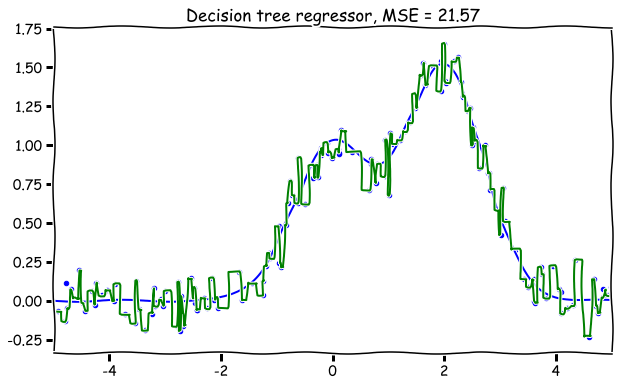

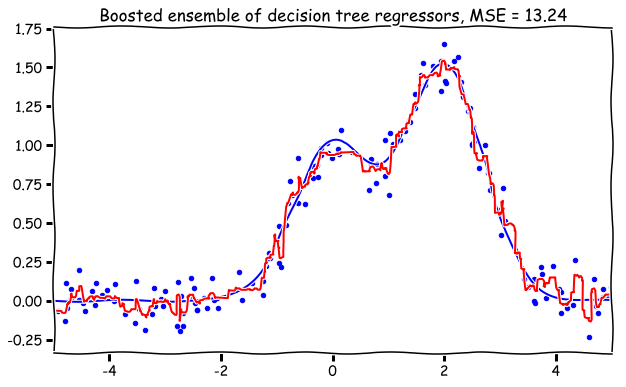

In [3]:
n_train = 150        
n_test = 1000       
noise = 0.1

# Generate data
def f(x):
    x = x.ravel()

    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2) +\
        np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))

    return X, y

X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)
# One decision tree regressor
dtree = DecisionTreeRegressor(random_state=42)

dtree.fit(X_train, y_train)
d_predict = dtree.predict(X_test)

with plt.xkcd():
    plt.figure(figsize=(10, 6))
    plt.plot(X_test, f(X_test), "b")
    plt.scatter(X_train, y_train, c="b", s=20)
    plt.plot(X_test, d_predict, "g", lw=2)
    plt.xlim([-5, 5])
    plt.title("Decision tree regressor, MSE = %.2f" % 
              np.sum((y_test - d_predict) ** 2))

    gbtree = GradientBoostingRegressor(n_estimators=100, subsample=0.5,
                                      random_state=42)  
    gbtree.fit(X_train, y_train)
    gb_predict = gbtree.predict(X_test)

    plt.figure(figsize=(10, 6))
    plt.plot(X_test, f(X_test), "b")
    plt.scatter(X_train, y_train, c="b", s=20)
    plt.plot(X_test, gb_predict, "r", lw=2)
    plt.xlim([-5, 5])
    plt.title("Boosted ensemble of decision tree regressors, MSE = %.2f" % 
              np.sum((y_test - gb_predict) ** 2));

Рассмотрим пример использования AdaBoostClassifier с деревья решений единичной глубины (decision stumps) в качестве базовых алгоритмов для решения задачи классификации.

In [4]:
# Загрузка данных о диабете индейцев Пима из репозитория машинного обучения UCI
pima_indians = "https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
raw_data = urlopen(url)
data = np.loadtxt(raw_data, delimiter=",")

X_train, X_test, y_train, y_test = train_test_split(data[:, :8], 
                                                    data[:, 8], 
                                                    random_state=0)

dt = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

# AdaBoost
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         random_state=42).fit(X_train, y_train)

print("Decision tree accuracy: %.2f" % dt.score(X_test, y_test))
print("AdaBoost accuracy: %.2f" % ada.score(X_test, y_test))

Decision tree accuracy: 0.71
AdaBoost accuracy: 0.79


Пример использования XGBoost для классификации на данных Iris.

In [5]:
iris = load_iris()
X = iris['data']
y = iris['target']
kf = KFold(n_splits=5, shuffle=True, random_state=13)
for train_index, test_index in kf.split(y):
    xgb_model = xgb.XGBClassifier().fit(X[train_index], y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    print(confusion_matrix(actuals, predictions))

[[ 9  0  0]
 [ 0  8  0]
 [ 0  2 11]]
[[10  0  0]
 [ 0  9  1]
 [ 0  1  9]]
[[9 0 0]
 [0 9 1]
 [0 2 9]]
[[12  0  0]
 [ 0 10  1]
 [ 0  0  7]]
[[10  0  0]
 [ 0 11  0]
 [ 0  0  9]]


Пример восстановления регрессии с XGBoost на данных boston.

In [6]:
boston = load_boston()
y = boston['target']
X = boston['data']
kf = KFold(n_splits=5, shuffle=True, random_state=17)
for train_index, test_index in kf.split(y):
    xgb_model = xgb.XGBRegressor().fit(X[train_index],y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    print(mean_squared_error(actuals, predictions))

8.0971394504
8.92640647601
18.299771839
6.73819144817
8.47392580766


Простой пример подбора параметров с GridSearchCV.

In [7]:
X = boston['data']
y = boston['target']

xgb_model = xgb.XGBRegressor()
xgb_grid = GridSearchCV(xgb_model,
                   {'max_depth': [2,4,6]}, verbose=1)
xgb_grid.fit(X,y)
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
0.598487960649
{'max_depth': 4}


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.1s finished


Ранняя остановка используется для того, чтобы прекратить обучение модели (градиентный спуск), если ошибка за несколько итераций не уменьшилась.

In [8]:
digits = load_digits()

X = digits['data']
y = digits['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=17)
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="merror",
        eval_set=[(X_test, y_test)])

[0]	validation_0-merror:0.177778
Will train until validation_0-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.157778
[2]	validation_0-merror:0.148889
[3]	validation_0-merror:0.135556
[4]	validation_0-merror:0.131111
[5]	validation_0-merror:0.122222
[6]	validation_0-merror:0.106667
[7]	validation_0-merror:0.104444
[8]	validation_0-merror:0.104444
[9]	validation_0-merror:0.102222
[10]	validation_0-merror:0.097778
[11]	validation_0-merror:0.097778
[12]	validation_0-merror:0.095556
[13]	validation_0-merror:0.095556
[14]	validation_0-merror:0.097778
[15]	validation_0-merror:0.097778
[16]	validation_0-merror:0.093333
[17]	validation_0-merror:0.088889
[18]	validation_0-merror:0.091111
[19]	validation_0-merror:0.093333
[20]	validation_0-merror:0.091111
[21]	validation_0-merror:0.086667
[22]	validation_0-merror:0.084444
[23]	validation_0-merror:0.082222
[24]	validation_0-merror:0.082222
[25]	validation_0-merror:0.082222
[26]	validation_0-merror:0.082222
[27]	validation_0-merror:

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

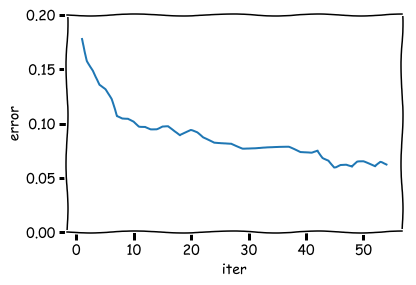

In [9]:
errors_by_iter = clf.evals_result()['validation_0']['merror']
plt.plot(range(1, len(errors_by_iter) + 1), errors_by_iter)
plt.xlabel('iter');
plt.ylabel('error');
plt.ylim(0, 0.2);

<a class="anchor" id="10.2"></a>

## 10.2 Сравнение XGBoost и градиентного бустинга Sklearn

[Вернуться к содержанию](#10)

<a class="anchor" id="10.2.1"></a>

### 10.2.1 Параметры алгоритма XGBoost

[Вернуться к содержанию](#10)

Выделяют три группы параметров XGBoost:
- Общие параметры, отвечающие за базовый алгоритм для бустинга и распараллеливание.
- Параметры выбранного базового алгоритма.
- Параметры обучения, отвечающие за функцию потерь и метрику качества на валидации.

**1. Общие параметры:**
- booster [default=gbtree] - тип базового алгоритма для бустинга: дерево решений gbtree или линейная модель gblinear. 
- silent [default=0] - выдавать (silent=0) или нет (silent=1) сообщения по ходу работы алгоритма.
- nthread [default to maximum number of threads available if not set] - число нитей доступных для параллельной работы XGBoost.

**2. Параметры базового алгоритма:**

**2.1. Дерево решений:**
- eta [default=0.3] - темп обучения, перед добавлением дерева в композицию оно умножается на eta. Используется для предотвращения переобучения за счёт "сокращения" весов базовых алгоритмов, делая модель более консервативной. Чем меньше eta, тем больше нужно итераций num_boost_round для обучения модели с хорошим качеством. Диапазон: [0, 1]
- gamma [default=0] - минимальное снижение значения функции потерь, необходимое для дальнейшего разбиения вершины дерева. Большие значения gamma > 0 приводят к более консервативным моделям. Диапазон: [0, $\infty$).
- max_depth [default=6] - максимальная глубина дерева. Диапазон: [1, $\infty$). 
- min_child_weight [default=1] - минимальное необходимое (взвешенное) число примеров в каждой вершине. Чем больше, тем более консервативна итоговая модель. Диапазон: [0, $\infty$).
- max_delta_step [default=0] - обычно равен нулю. Положительные значения используются при несбалансированных классах для ускорения сходимости. Диапазон [0, $\infty$).
- subsample [default=1] - доля выборки, используемая для обучения каждого дерева. Если subsample < 1, то выбирается случайная подвыборка, что помогает в борьбе с переобучением. Диапазон: (0, 1]
- colsample_bytree [default=1] - доля признаков, используемая для обучения каждого дерева. Диапазон: (0, 1]
- lambda [default=1] - коэффициент перед $L_2$-регуляризатором в функции потерь.
- alpha [default=0] - коэффициент перед $L_1$-регуляризатором в функции потерь.

**2.2. Линейная модель:**
- lambda [default=0] - коэффициент перед $L_2$-регуляризатором вектора весов в функции потерь.
- alpha [default=0] - коэффициент перед $L_1$-регуляризатором вектора весов в функции потерь.
- lambda_bias [default=0] - коэффициент перед $L_2$-регуляризатором смещения (свободного члена) в функции потерь.

**3. Параметры задачи обучения:**
- objective [default=reg:linear] - используемая при обучении функция потерь:
    - "reg:linear" – линейная регрессия.
    - "reg:logistic" – логистическая регрессия.
    - "binary:logistic" – логистическая регрессия для бинарной классификации, на выходе - вероятность.
    - "binary:logitraw" – то же самое, но на выходе - значение до его преобразования логистической функцией.
    - "count:poisson" – регрессия Пуассона (используется для оценки числа каких-то событий, счётный признак), на выходе - матожидания распределения Пуассона. В этом случае max_delta_step автоматически устанавливается равным 0.7.
    - "multi:softmax" – обобщение логистической регрессии на многоклассовый случай. При этом нужно задать параметр num_class.
    - "multi:softprob" – то же самое, но на выходе - вектор размера ndata * nclass, который можно преобразовать в матрицу, содержащую вероятности отнесения данного объекта к данному классу.
    - "rank:pairwise" – используется для задач ранжирования.
- base_score [default=0.5] - инициализация значения модели для всех примеров, глобальное смещение.
- eval_metric [default according to objective] - метрика качества на валидационной выборке (по умолчанию соответствует функции потерь: rmse - для регрессии, error - для классификации, mean average precision - для ранжирования). Выбрать можно одну из следующих метрик:
    - "rmse": root mean square error.
    - "logloss": минус логарифм правдоподобия.
    - "error": доля ошибок для бинарной классификации.
    - "merror": то же самое для многоклассовой классификации.
    - "mlogloss": logloss для многоклассовой классификации.
    - "auc": AUC.
    - "ndcg": Normalized Discounted Cumulative Gain.
    - "map": Mean average precision.
    - "ndcg@n",”map@n”: здесь n - целое число, первые n позиций в списке не учитываются.
    - "ndcg-",”map-”,”ndcg@n-”,”map@n-”: списку из всех положительных примеров будет присвоено значение 0 (вместо 1).
- seed [default=0] - для воспроизводимости "случайности".

**4. Параметры в XGBoost.train**:
- params (dict) – параметры, описанные выше.
- dtrain (DMatrix) – обучающая выборка.
- num_boost_round (int) – число итераций бустинга.
- evals (list) – список для оценки качества во время обучения.
- obj (function) – собственная функция потерь.
- feval (function) – собственная функция для оценки качества.
- maximize (bool) – нужно ли максимизировать feval.
- early_stopping_rounds (int) – активирует early stopping. Ошибка на валидации должна уменьшаться каждые early_stopping_rounds итераций для продолжения обучения. Список evals должен быть не пуст. Возвращается модель с последней итерации. Если произошел ранний останов, то модель будет содержать поля: bst.best_score и bst.best_iteration.
- evals_result (dict) – результаты оценки качества.
- verbose_eval (bool) – вывод значения метрики качества на каждой итерации бустинга.
- learning_rates (list or function) – коэффициент скорости обучения для каждой итерации - list l: eta = l[boosting round] - function f: eta = f(boosting round, num_boost_round).
- xgb_model (file name of stored xgb model or ‘Booster’ instance) – возможность продолжить обучения имеющейся модели XGB.



**5. sklearn.ensemble.GradientBoostingClassifier**

- loss [default="deviance"] - оптимизируемая функция потерь.  Одна из {"deviance", "exponential"}. Первая соответствует логистической регрессии и возвращает вероятности, вторая - AdaBoost.
- learning_rate [default=0.1] - темп обучения, аналогично eta для XGBoost.
- n_estimators [default=100] - число итераций градиентного бустинга.
- max_depth [default=3] - аналогично max_depth для XGBoost.
- min_samples_split [default=2] - минимальное число примеров, необходимое для разветвления в данной вершине,  аналогично min_child_weight для XGBoost.
- min_samples_leaf [default=1] - минимальное число примеров в листе.
- min_weight_fraction_leaf [default=0.0] - минимальное взвешенное число примеров в листе.
- subsample [default=1.0] - аналогично subsample для XGBoost.
- max_features (int, float, string or None) [default=None] - число (или доля) признаков, используемых при разбиении вершины.
    - "auto", тогда max_features=sqrt(n_features).
    - "sqrt", тогда max_features=sqrt(n_features).
    - "log2", тогда max_features=log2(n_features).
    - None, тогда max_features=n_features.
- max_leaf_nodes [default=None]
- init (BaseEstimator or None) [default=None] - алгоритм для начальных предсказаний.
- verbose [default=0] - аналогично silent для XGBoost.
- warm_start [default=False] - если True, используется ансамбль с предыдущего вызова fit, новые алгоритмы добавляются к нему, иначе строится новый алгоритм.

<a class="anchor" id="10.2.2"></a>

### 10.2.2 Сравнение алгоритмов по времени работы

[Вернуться к содержанию](#10)

Посмотрим на время обучения классификаторов XGBooster и GradientBoostingClassifier. Для этого будем генерировать выборку из 1000 объектов и 50 признаков с помощью sklearn.datasets.make_classification и замерять время обучения.

In [1]:
import time
from tqdm import tqdm_notebook
import XGBoost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_classification

xgb_params1 = {'booster': 'gbtree', 'max_depth': 3, 'eta': 0.1, 
    'silent': 1, 'objective': 'binary:logistic', 'nthread': 1}
xgb_params2 = {'booster': 'gbtree', 'max_depth': 3, 'eta': 0.1, 
    'silent': 1, 'objective': 'binary:logistic', 'nthread': 4}
sklearn_params = {'n_estimators': 100, 'max_depth': 3}

xgb_time1 = list()
xgb_time2 = list()
sklearn_time = list()

n_runs = 50

for i in tqdm_notebook(range(n_runs)):
    # Generating dataset
    X, y = make_classification(n_samples=1000, n_features=50, 
                               n_informative=20)
    # Training XGBooster (nthread=1)
    t = time.time()
    bst = xgb.train(xgb_params1, xgb.DMatrix(X, label=y), 
                    num_boost_round=100)
    elapsed = time.time() - t
    xgb_time1.append(elapsed)
    # Training XGBooster (nthread=4)
    t = time.time()
    bst = xgb.train(xgb_params2, xgb.DMatrix(X, label=y), 
                    num_boost_round=100)
    elapsed = time.time() - t
    xgb_time2.append(elapsed)
    # Training GradientBoostingClassifier
    t = time.time()
    clf = GradientBoostingClassifier(**sklearn_params).fit(X, y)
    elapsed = time.time() - t
    sklearn_time.append(elapsed)

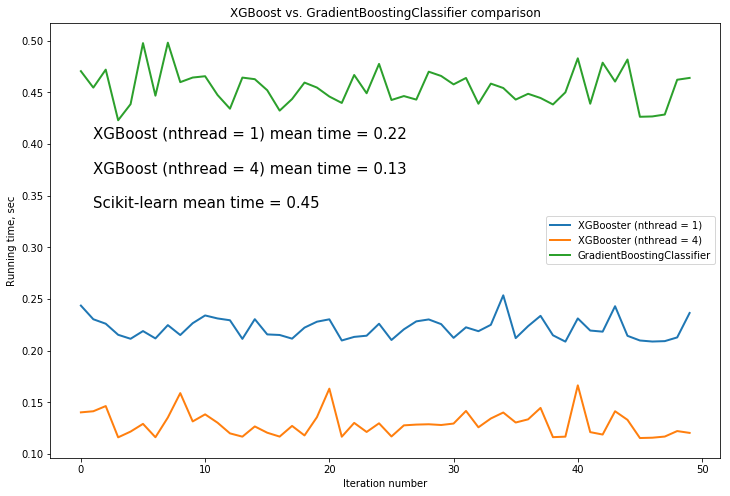

In [2]:
%matplotlib  inline
import matplotlib.pyplot as plt

xgb_mean1 = sum(xgb_time1) / n_runs
xgb_mean2 = sum(xgb_time2) / n_runs
sklearn_mean = sum(sklearn_time) / n_runs

plt.figure(figsize=(12, 8))
plt.plot(xgb_time1, label='XGBooster (nthread = 1)', lw=2)
plt.plot(xgb_time2, label='XGBooster (nthread = 4)', lw=2)
plt.plot(sklearn_time, label='GradientBoostingClassifier', lw=2)
plt.legend(loc='best')
plt.text(1, (xgb_mean1 + sklearn_mean) / 2, 
         'XGBoost (nthread = 1) mean time = %.2f' % xgb_mean1 +
         '\n\nXGBoost (nthread = 4) mean time = %.2f' % xgb_mean2 +
         '\n\nScikit-learn mean time = %.2f' % sklearn_mean,
            fontsize = 15)
plt.xlabel('Iteration number')
plt.ylabel('Running time, sec')
plt.title('XGBoost vs. GradientBoostingClassifier comparison')
plt.show()

<a class="anchor" id="10.3"></a>

## 10.3 XGBoost, стандартный Python-интерфейс

[Вернуться к содержанию](#10)

**Загрузка бибилиотек**

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import XGBoost as xgb

<a class="anchor" id="10.3.1"></a>

### 10.3.1 Загрузка и подготовка данных

[Вернуться к содержанию](#10)

Посмотрим на примере данных по оттоку клиентов из телеком-компании.

> **Важно**: XGBoost поддерживает только числовые признаки. Поэтому текстовые признаки требуют предобработки

Для обучения с XGBoost данные должны быть представлены в виде объекта `DMatrix`, предназначенного для представления разреженных данных. Его можно инициализировать через:
- текстовый формат libsvm,
-  Numpy 2D array (чаще всего)
- бинарный буфер-файл XGBoost 

Загрузим данные и осуществим минимальную предобработку.

In [2]:
telecom_churn = 'https://raw.githubusercontent.com/soolstafir/Machine-learning-course/master/Lections/ml_lection-10-boosting/telecom_churn.csv'
df = pd.read_csv(telecom_churn)

In [3]:
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


Штаты просто занумеруем (хотя можно и лучше поступить), а признаки International plan (наличие международного роуминга), Voice mail plan (наличие голосовой почтыы) и целевой Churn сделаем бинарными.

In [4]:
state_enc = LabelEncoder()
df['State'] = state_enc.fit_transform(df['State'])
df['International plan'] = (df['International plan'] == 'Yes').astype('int')
df['Voice mail plan'] = (df['Voice mail plan'] == 'Yes').astype('int')
df['Churn'] = (df['Churn']).astype('int')

Разделим данные на обучающую и тестовую выборки в отношении 7:3. Инициализируем соотв. объекты DMatrix dtrain и dtest.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Churn', axis=1), df['Churn'],
                                                    test_size=0.3, stratify=df['Churn'], random_state=17)
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

Посмотрим на статистику полученных объектов:

In [6]:
print("Train dataset contains {0} rows and {1} columns".format(dtrain.num_row(), dtrain.num_col()))
print("Test dataset contains {0} rows and {1} columns".format(dtest.num_row(), dtest.num_col()))

Train dataset contains 2333 rows and 19 columns
Test dataset contains 1000 rows and 19 columns


In [7]:
print("Train mean target: ")
print(np.mean(dtrain.get_label()))

print("\nTest mean target: ")
print(np.mean(dtest.get_label()))

Train mean target: 
0.144878

Test mean target: 
0.145


<a class="anchor" id="10.3.2"></a>

### 10.3.2 Инициализация параметров

[Вернуться к содержанию](#10)

- бинарная классификация (`'objective':'binary:logistic'`)
- ограничим глубину деревьев (`'max_depth':3`)
- не хотим лишнего вывода (`'silent':1`)
- проведем 50 итераций бустинга
- шаг градиентного спуска довольно большой (`'eta':1`) - алгоритм будет обучаться быстро и "агрессивно" (лучше результаты будут, если уменьшить eta и увеличить число итераций)

In [8]:
params = {
    'objective':'binary:logistic',
    'max_depth': 3,
    'silent': 1,
    'eta': 1
}

num_rounds = 50

<a class="anchor" id="10.3.3"></a>

### 10.3.3 Обучение классификатора

[Вернуться к содержанию](#10)

Тут мы просто передаем слоавть параметров, данные и число итераций.

In [9]:
xgb_model = xgb.train(params, dtrain, num_rounds)

С помощью `watchlist` отслеживать качество алгоритма на тестовой выборке для каждой итерации.

In [10]:
watchlist  = [(dtest,'test'), (dtrain,'train')] # native interface only
xgb_model = xgb.train(params, dtrain, num_rounds, watchlist)

[0]	test-error:0.116	train-error:0.09087
[1]	test-error:0.102	train-error:0.068581
[2]	test-error:0.071	train-error:0.040291
[3]	test-error:0.064	train-error:0.034719
[4]	test-error:0.071	train-error:0.036005
[5]	test-error:0.07	train-error:0.033862
[6]	test-error:0.069	train-error:0.032147
[7]	test-error:0.073	train-error:0.030433
[8]	test-error:0.07	train-error:0.028718
[9]	test-error:0.074	train-error:0.028718
[10]	test-error:0.07	train-error:0.02829
[11]	test-error:0.07	train-error:0.028718
[12]	test-error:0.063	train-error:0.026575
[13]	test-error:0.067	train-error:0.024432
[14]	test-error:0.069	train-error:0.02186
[15]	test-error:0.069	train-error:0.021432
[16]	test-error:0.068	train-error:0.02186
[17]	test-error:0.063	train-error:0.019288
[18]	test-error:0.07	train-error:0.021003
[19]	test-error:0.067	train-error:0.01886
[20]	test-error:0.069	train-error:0.019288
[21]	test-error:0.068	train-error:0.018003
[22]	test-error:0.065	train-error:0.016717
[23]	test-error:0.063	train-err

#### Прогнозы для тестовой выборки

In [11]:
preds_prob = xgb_model.predict(dtest)

Посчитаем долю правильных ответов алгоритма на тестовой выборке.

In [12]:
predicted_labels = preds_prob > 0.5
print("Accuracy and F1 on the test set are: {} and {}".format(
    round(accuracy_score(y_test, predicted_labels), 3),
    round(f1_score(y_test, predicted_labels), 3)))

Accuracy and F1 on the test set are: 0.935 and 0.749


<a class="anchor" id="10.4"></a>

## 10.4 XGBoost, интерфейс Sklearn

[Вернуться к содержанию](#10)

**Загрузка бибилиотек**

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from XGBoost import XGBClassifier

#### Загрузка и подготовка данных

Посмотрим на примере данных по оттоку клиентов из телеком-компании.

In [2]:
df = pd.read_csv(telecom_churn)

In [3]:
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


Штаты просто занумеруем, а признаки International plan (наличие международного роуминга), Voice mail plan (наличие голосовой почтыы) и целевой Churn сделаем бинарными.

In [4]:
state_enc = LabelEncoder()
df['State'] = state_enc.fit_transform(df['State'])
df['International plan'] = (df['International plan'] == 'Yes').astype('int')
df['Voice mail plan'] = (df['Voice mail plan'] == 'Yes').astype('int')
df['Churn'] = (df['Churn']).astype('int')

Разделим данные на обучающую и тестовую выборки в отношении 7:3.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Churn', axis=1), df['Churn'],
                                                    test_size=0.3, stratify=df['Churn'], random_state=17)

#### Инициализация параметров

- бинарная классификация (`'objective':'binary:logistic'`)
- ограничим глубину деревьев (`'max_depth':3`)
- не хотим лишнего вывода (`'silent':1`)
- проведем 10 итераций бустинга
- шаг градиентного спуска довольно большой (`'eta':1`) - алгоритм будет обучаться быстро и "агрессивно" (лучше результаты будут, если уменьшить eta и увеличить число итераций)

In [6]:
params = {
    'objective': 'binary:logistic',
    'max_depth': 3,
    'learning_rate': 1.0,
    'silent': 1.0,
    'n_estimators': 50
}

#### Обучение классификатора
Тут мы просто передаем слоавть параметров, данные и число итераций.

In [7]:
xgb_model = XGBClassifier(**params).fit(X_train, y_train)

#### Прогнозы для тестовой выборки

In [8]:
preds_prob = xgb_model.predict(X_test)

Посчитаем долю правильных ответов алгоритма на тестовой выборке.

In [9]:
predicted_labels = preds_prob > 0.5
print("Accuracy and F1 on the test set are: {} and {}".format(
    round(accuracy_score(y_test, predicted_labels), 3),
    round(f1_score(y_test, predicted_labels), 3)))

Accuracy and F1 on the test set are: 0.935 and 0.749


<a class="anchor" id="10.5"></a>

## 10.5 Оценка важности признаков с XGBoost

[Вернуться к содержанию](#10)

**Загрузка бибилиотек**

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(font_scale = 1.5)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import XGBoost as xgb

#### Загрузка и подготовка данных

Посмотрим на примере данных по оттоку клиентов из телеком-компании.### Load data<a name='data' />

In [3]:
df = pd.read_csv(telecom_churn)

In [4]:
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


Штаты просто занумеруем, а признаки International plan (наличие международного роуминга), Voice mail plan (наличие голосовой почтыы) и целевой Churn сделаем бинарными.

In [5]:
state_enc = LabelEncoder()
df['State'] = state_enc.fit_transform(df['State'])
df['International plan'] = (df['International plan'] == 'Yes').astype('int')
df['Voice mail plan'] = (df['Voice mail plan'] == 'Yes').astype('int')
df['Churn'] = (df['Churn']).astype('int')

Разделим данные на обучающую и тестовую выборки в отношении 7:3. Инициализируем соотв. объекты DMatrix dtrain и dtest.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Churn', axis=1), df['Churn'],
                                                    test_size=0.3, stratify=df['Churn'], random_state=17)
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

#### Обучение модели

Обучим всего 50 деревьев решений глубины 3.

In [7]:
params = {
    'objective':'binary:logistic',
    'max_depth':3,
    'silent':1,
    'eta':0.5
}

num_rounds = 50

In [8]:
watchlist  = [(dtest,'test'), (dtrain,'train')] # native interface only
xgb_model = xgb.train(params, dtrain, num_rounds, watchlist)

[0]	test-error:0.116	train-error:0.09087
[1]	test-error:0.104	train-error:0.069867
[2]	test-error:0.089	train-error:0.061723
[3]	test-error:0.092	train-error:0.054008
[4]	test-error:0.075	train-error:0.041149
[5]	test-error:0.074	train-error:0.038148
[6]	test-error:0.07	train-error:0.035148
[7]	test-error:0.069	train-error:0.033005
[8]	test-error:0.069	train-error:0.033433
[9]	test-error:0.068	train-error:0.029147
[10]	test-error:0.066	train-error:0.031719
[11]	test-error:0.068	train-error:0.028718
[12]	test-error:0.068	train-error:0.027004
[13]	test-error:0.069	train-error:0.027004
[14]	test-error:0.07	train-error:0.027004
[15]	test-error:0.071	train-error:0.026575
[16]	test-error:0.069	train-error:0.025718
[17]	test-error:0.07	train-error:0.025718
[18]	test-error:0.068	train-error:0.025718
[19]	test-error:0.071	train-error:0.025718
[20]	test-error:0.07	train-error:0.026147
[21]	test-error:0.069	train-error:0.025289
[22]	test-error:0.069	train-error:0.025718
[23]	test-error:0.068	trai

#### Важность признаков

F score при оценке важности признаков в XGBoost (не путать с F1 score как метрики качества классификации) вычисляется на основе того, как часто разбиение делалось по данному признаку.

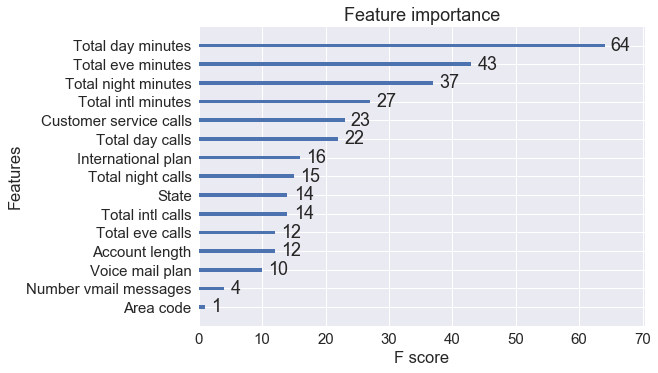

In [9]:
xgb.plot_importance(xgb_model);

Можно так, в виде словаря или DataFrame:

In [10]:
importances = xgb_model.get_fscore()
importances

{'Account length': 12,
 'Area code': 1,
 'Customer service calls': 23,
 'International plan': 16,
 'Number vmail messages': 4,
 'State': 14,
 'Total day calls': 22,
 'Total day minutes': 64,
 'Total eve calls': 12,
 'Total eve minutes': 43,
 'Total intl calls': 14,
 'Total intl minutes': 27,
 'Total night calls': 15,
 'Total night minutes': 37,
 'Voice mail plan': 10}

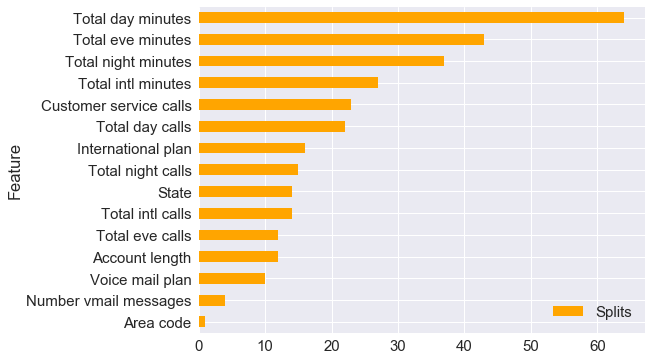

In [12]:
# create df
importance_df = pd.DataFrame({
        'Splits': list(importances.values()),
        'Feature': list(importances.keys())
    })
importance_df.sort_values(by='Splits', inplace=True)
importance_df.plot(kind='barh', x='Feature', figsize=(8,6), color='orange');

<a class="anchor" id="10.6"></a>

## 10.6 Борьба с недообучением и переобучением XGBoost

[Вернуться к содержанию](#10)

Построим кривые вадидации XGBoost по числу деревьев в задаче классификации синтетических данных.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from XGBoost.sklearn import XGBClassifier
from scipy.sparse import vstack

Генерируем синтетические данные.

In [2]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=8, 
                           n_redundant=3, n_repeated=2, random_state=42)

Будем проводить 10-кратную стратифицированную кросс-валидацию. По умолчанию в статьях по машинному обучению и статистике используется именно такая.

In [3]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

Посмотрим, как число деревьев влияет на качество модели.

In [4]:
default_params = {
    'objective': 'binary:logistic',
    'max_depth': 1,
    'learning_rate': 0.3,
    'silent': 1.0,
    'seed': 42
}

n_estimators_range = np.linspace(1, 200, 10).astype('int')

train_scores, test_scores = validation_curve(
    XGBClassifier(**default_params),
    X, y,
    param_name = 'n_estimators',
    param_range = n_estimators_range,
    cv=cv.split(X, y),
    scoring='accuracy',
    n_jobs=-1
)

Построим кривые валидации.

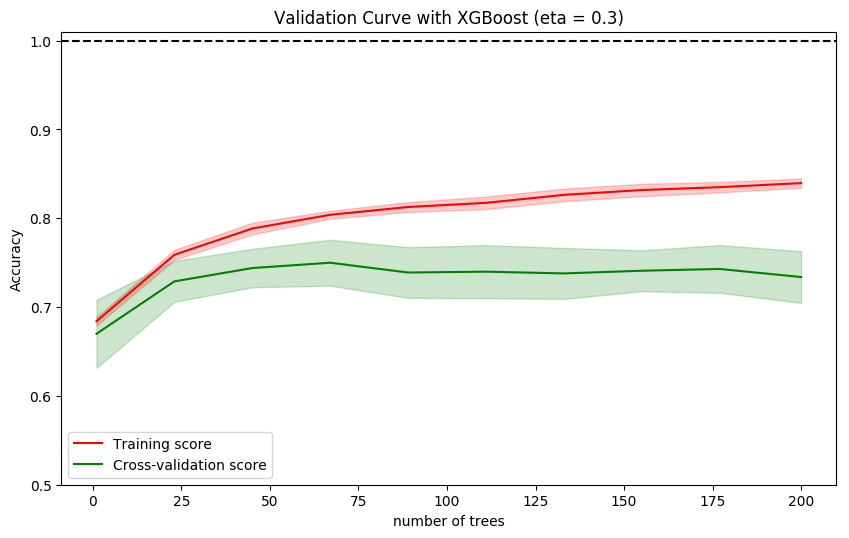

Best cross-validation result (0.75) obtained for 67 trees


In [5]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(10, 6), dpi=100)

plt.title("Validation Curve with XGBoost (eta = 0.3)")
plt.xlabel("number of trees")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.01)

plt.plot(n_estimators_range,
             train_scores_mean,
             label="Training score",
             color="r")

plt.plot(n_estimators_range,
             test_scores_mean, 
             label="Cross-validation score",
             color="g")

plt.fill_between(n_estimators_range, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.2, color="r")

plt.fill_between(n_estimators_range,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.2, color="g")

plt.axhline(y=1, color='k', ls='dashed')

plt.legend(loc="best")
plt.show()

i = np.argmax(test_scores_mean)
print("Best cross-validation result ({0:.2f}) obtained for {1} trees".format(test_scores_mean[i], 
                                                                             n_estimators_range[i]))

**Что заметно:**

- Доля правильных ответов на обучении продолжает расти, хотя на валидации - уже нет
- Когда деревьев меньше 25 разброс (variance) ошибки невелик, но и смещение (bias) велико
- Начиная с 25 деревьев, разброс ошибки начинает расти
- Модель доаольно стабильна: дальнейшее увеличение ее сложности не приводит к увеличению разброса ошибки.

Оптимальное в данном случае сочетание разброса и смещение наблюдается примерно при 50 итерациях. Хотя разброс все же велик.

#### Что можно улучшить?

**Снижение разброса**

Для уменьшения сложности модели можно:
- использовать меньше признаков (например, отбор)
- использовать больше объектов (например, искусственно созданных)
- увеличить регуляризацию

В случае XGBoost можно:
- уменьшать максимальную глубину деревьев(`max_depth`)
- увеличивать значение параметра `min_child_weight`
- увеличивать значение параметра `gamma`
- добавлять больше "случайности" за счет параметров `subsample` и `colsample_bytree`
- увеличивать значение паарметров регуляризации `lambda` и `alpha`

**Снижение смещения**

Если модель слишком простая, можно:
- добавлять больше признаков (например, изобретать их),
- усложнять модель
- уменьшать регуляризацию

В случае XGBoost можно:
- увеличивать максимальную глубину деревьев(`max_depth`)
- уменьшать значение параметра `min_child_weight`
- уменьшать значение параметра `gamma`
- уменьшать значение параметров регуляризации `lambda` и `alpha`

Попробуем немного настроить параметры. Будем для построения каждого дерева использовать в среднем 70% случайно выбранных объектов и 60% случайно выбранных признаков. Это уменьшит разброс ошибки. Для уменьшения смещения увеличим на 1 максимальную глубину деревьев.

In [6]:
new_params = {
    'objective': 'binary:logistic',
    'max_depth': 2, # changed
    'learning_rate': 0.3,
    'silent': 1.0,
    'colsample_bytree': 0.6, # added
    'subsample': 0.7, # added
    'seed': 42
}

n_estimators_range = np.linspace(1, 200, 10).astype('int')

train_scores, test_scores = validation_curve(
    XGBClassifier(**new_params),
    X, y,
    param_name = 'n_estimators',
    param_range = n_estimators_range,
    cv=cv.split(X, y),
    scoring='accuracy'
)

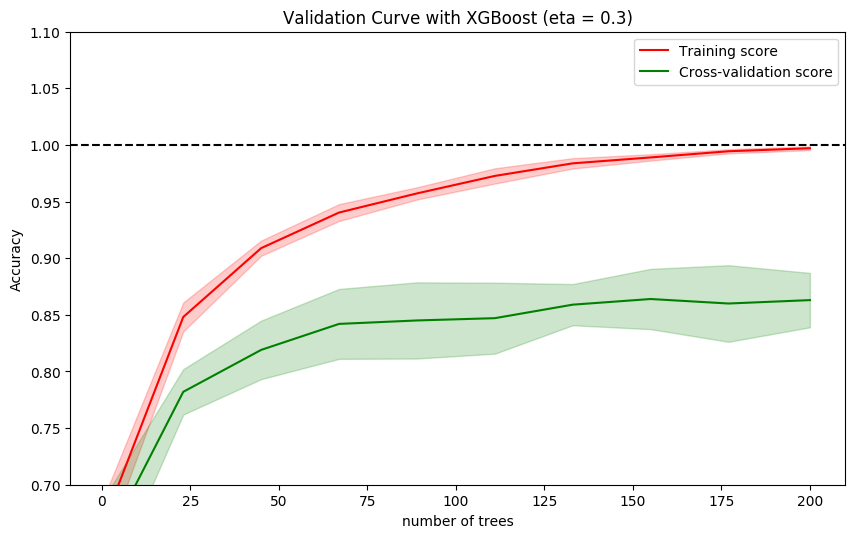

Best cross-validation result (0.86) obtained for 155 trees


In [7]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(10, 6), dpi=100)

plt.title("Validation Curve with XGBoost (eta = 0.3)")
plt.xlabel("number of trees")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1.1)

plt.plot(n_estimators_range,
             train_scores_mean,
             label="Training score",
             color="r")

plt.plot(n_estimators_range,
             test_scores_mean, 
             label="Cross-validation score",
             color="g")

plt.fill_between(n_estimators_range, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.2, color="r")

plt.fill_between(n_estimators_range,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.2, color="g")

plt.axhline(y=1, color='k', ls='dashed')

plt.legend(loc="best")
plt.show()

i = np.argmax(test_scores_mean)
print("Best cross-validation result ({0:.2f}) obtained for {1} trees".format(test_scores_mean[i], n_estimators_range[i]))

<a class="anchor" id="10.7"></a>

## 10.7 XGBoost и Hyperopt в соревновании Kaggle Forest Cover Type Prediction

[Вернуться к содержанию](#10)

[Соревнование](https://www.kaggle.com/c/forest-cover-type-prediction). 
Задача учебная. Предлагается предсказывать тип лесного покрытия на участках 30х30 метров Национального заповедника Рузвельта в Колорадо.

Признаки (подробней на [странице](https://www.kaggle.com/c/forest-cover-type-prediction/data) соревнования):

- Elevation (высота) - Elevation in meters
- Aspect - Aspect in degrees azimuth
- Slope (наклон) - Slope in degrees
- Horizontal_Distance_To_Hydrology (горизонтальное расстояние до воды) - Horz Dist to nearest surface water features
- Vertical_Distance_To_Hydrology (вертикальное расстояние до воды) - Vert Dist to nearest surface water features
- Horizontal_Distance_To_Roadways (горизонтальное расстояние до дорог) - Horz Dist to nearest roadway
- Hillshade_9am (0 to 255 index) - Hillshade index at 9am, summer solstice
- Hillshade_Noon (0 to 255 index) - Hillshade index at noon, summer solstice
- Hillshade_3pm (0 to 255 index) - Hillshade index at 3pm, summer solstice 
- Horizontal_Distance_To_Fire_Points (горизонтальное расстояние до центров воспламенения) - Horz Dist to nearest wildfire ignition points 
- Wilderness_Area (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation
- Soil_Type (тип почвы) - (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation
Cover_Type (7 types, integers 1 to 7) - Forest Cover Type designation

Подключаем библиотеки и загружаем данные. Используем [log_progress](https://github.com/alexanderkuk/log-progress) для отслеживания итераций в циклах.

In [1]:
import numpy as np
import pandas as pd
import XGBoost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
forest_train = 'https://raw.githubusercontent.com/soolstafir/Machine-learning-course/master/Lections/ml_lection-10-boosting/forest_train.csv'
forest_test = 'https://raw.githubusercontent.com/soolstafir/Machine-learning-course/master/Lections/ml_lection-10-boosting/forest_test.csv'
forest_cover_type_XGBoost_csv = 'https://raw.githubusercontent.com/soolstafir/Machine-learning-course/master/Lections/ml_lection-10-boosting/sampleSubmission.csv'

In [2]:
train_df = pd.read_csv(forest_train)
test_df = pd.read_csv(forest_test)

In [3]:
def write_to_submission_file(predicted_labels, out_file,
                             target='Cover_Type', index_label="Id", init_index=15121):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(init_index, 
                                                  predicted_labels.shape[0] + init_index),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

Создаем признаки.

In [4]:
train_df['Under_water'] = train_df.Vertical_Distance_To_Hydrology < 0
test_df['Under_water'] = test_df.Vertical_Distance_To_Hydrology < 0

In [5]:
train_df['EVDtH'] = train_df.Elevation - train_df.Vertical_Distance_To_Hydrology
test_df['EVDtH'] = test_df.Elevation - test_df.Vertical_Distance_To_Hydrology

train_df['EHDtH'] = train_df.Elevation - train_df.Horizontal_Distance_To_Hydrology*0.2
test_df['EHDtH'] = test_df.Elevation - test_df.Horizontal_Distance_To_Hydrology*0.2

In [6]:
train_df['Distanse_to_Hydrolody'] = (train_df['Horizontal_Distance_To_Hydrology'] ** 2 + 
                                  train_df['Vertical_Distance_To_Hydrology']**2) ** 0.5
test_df['Distanse_to_Hydrolody'] = (test_df['Horizontal_Distance_To_Hydrology']**2 + 
                                 test_df['Vertical_Distance_To_Hydrology']**2) ** 0.5

train_df['Hydro_Fire_1'] = train_df['Horizontal_Distance_To_Hydrology'] + \
    train_df['Horizontal_Distance_To_Fire_Points']
test_df['Hydro_Fire_1'] = test_df['Horizontal_Distance_To_Hydrology'] + \
    test_df['Horizontal_Distance_To_Fire_Points']

train_df['Hydro_Fire_2'] = abs(train_df['Horizontal_Distance_To_Hydrology'] - \
                                train_df['Horizontal_Distance_To_Fire_Points'])
test_df['Hydro_Fire_2'] = abs(test_df['Horizontal_Distance_To_Hydrology'] - \
                           test_df['Horizontal_Distance_To_Fire_Points'])

train_df['Hydro_Road_1'] = abs(train_df['Horizontal_Distance_To_Hydrology'] + \
                            train_df['Horizontal_Distance_To_Roadways'])
test_df['Hydro_Road_1'] = abs(test_df['Horizontal_Distance_To_Hydrology'] + \
                           test_df['Horizontal_Distance_To_Roadways'])

train_df['Hydro_Road_2'] = abs(train_df['Horizontal_Distance_To_Hydrology'] - \
                            train_df['Horizontal_Distance_To_Roadways'])
test_df['Hydro_Road_2'] = abs(test_df['Horizontal_Distance_To_Hydrology'] - \
                           test_df['Horizontal_Distance_To_Roadways'])

train_df['Fire_Road_1'] = abs(train_df['Horizontal_Distance_To_Fire_Points'] + \
                           train_df['Horizontal_Distance_To_Roadways'])
test_df['Fire_Road_1'] = abs(test_df['Horizontal_Distance_To_Fire_Points'] + \
                          test_df['Horizontal_Distance_To_Roadways'])

train_df['Fire_Road_2'] = abs(train_df['Horizontal_Distance_To_Fire_Points'] - \
                           train_df['Horizontal_Distance_To_Roadways'])
test_df['Fire_Road_2'] = abs(test_df['Horizontal_Distance_To_Fire_Points'] - \
                          test_df['Horizontal_Distance_To_Roadways'])

In [7]:
y = train_df['Cover_Type']
train_df = train_df.drop(['Cover_Type', 'Id'], axis=1)
test_df = test_df.drop(['Id'], axis=1)

In [8]:
y = y - 1 # Чтоб классы нумеровались от о до 6

In [9]:
from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [10]:
def score(params):
    from sklearn.metrics import log_loss
    print("Training with params:")
    print(params)
    params['max_depth'] = int(params['max_depth'])
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)
    model = xgb.train(params, dtrain, params['num_round'])
    predictions = model.predict(dvalid).reshape((X_test.shape[0], 7))
    score = log_loss(y_test, predictions)
    print("\tScore {0}\n\n".format(score))
    return {'loss': score, 'status': STATUS_OK}

In [11]:
def optimize(trials):
    space = {
             'num_round': 100,
             'learning_rate': hp.quniform('eta', 0.005, 0.05, 0.005),
             'max_depth': hp.quniform('max_depth', 3, 14, 1),
             'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
             'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
             'gamma': hp.quniform('gamma', 0.5, 1, 0.01),
             'colsample_bytree': hp.quniform('colsample_bytree', 0.4, 1, 0.05),
             'num_class' : 7,
             'eval_metric': 'merror',
             'objective': 'multi:softprob',
             'nthread' : 4,
             'silent' : 1
             }
    
    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=10)
    return best

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    train_df, y, test_size=0.3, random_state=17)

In [13]:
trials = Trials()
best_params = optimize(trials)
best_params

Training with params:
{'colsample_bytree': 0.8500000000000001, 'eval_metric': 'merror', 'gamma': 0.72, 'learning_rate': 0.035, 'max_depth': 5.0, 'min_child_weight': 3.0, 'nthread': 4, 'num_class': 7, 'num_round': 100, 'objective': 'multi:softprob', 'silent': 1, 'subsample': 0.75}
	Score 0.6115386063632157


Training with params:
{'colsample_bytree': 0.45, 'eval_metric': 'merror', 'gamma': 0.78, 'learning_rate': 0.025, 'max_depth': 7.0, 'min_child_weight': 4.0, 'nthread': 4, 'num_class': 7, 'num_round': 100, 'objective': 'multi:softprob', 'silent': 1, 'subsample': 0.8}
	Score 0.6466456986208179


Training with params:
{'colsample_bytree': 0.9, 'eval_metric': 'merror', 'gamma': 0.58, 'learning_rate': 0.02, 'max_depth': 10.0, 'min_child_weight': 2.0, 'nthread': 4, 'num_class': 7, 'num_round': 100, 'objective': 'multi:softprob', 'silent': 1, 'subsample': 0.75}
	Score 0.6240212209227066


Training with params:
{'colsample_bytree': 0.6000000000000001, 'eval_metric': 'merror', 'gamma': 0.53, 

{'colsample_bytree': 0.6000000000000001,
 'eta': 0.04,
 'gamma': 0.78,
 'max_depth': 10.0,
 'min_child_weight': 7.0,
 'subsample': 0.8500000000000001}

In [17]:
best_params['max_depth'] = int(best_params['max_depth'])
best_params['num_class'] = 7
best_params['eval_metric'] = 'merror'
best_params['objective'] = 'multi:softprob'
best_params['nthread'] = 4
best_params['silent'] = 1

In [18]:
dtrain = xgb.DMatrix(train_df, y)

In [19]:
%%time
xgbCvResult = xgb.cv(best_params, dtrain, 
                      num_boost_round=500,  
                      nfold=3, early_stopping_rounds=50)

CPU times: user 7min 34s, sys: 26.1 s, total: 8min
Wall time: 2min 26s


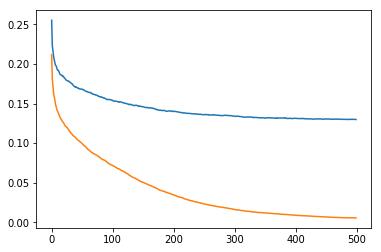

In [21]:
plt.plot(range(xgbCvResult.shape[0]), xgbCvResult['test-merror-mean'])
plt.plot(range(xgbCvResult.shape[0]), xgbCvResult['train-merror-mean']);

In [23]:
best_num_round = np.argmin(xgbCvResult['test-merror-mean'])
best_num_round

497

In [31]:
xgb.train?

Сделаем прогноз для всей тестовой выборки.

In [32]:
bestXgb = xgb.train(best_params, dtrain, num_boost_round=best_num_round)

In [33]:
dtest = xgb.DMatrix(test_df)

In [34]:
XGBoost_predict_proba = bestXgb.predict(dtest)

In [35]:
XGBoost_prediction = np.argmax(XGBoost_predict_proba,
                                         axis=1)

Мы вычитали из целевых меток 1, теперь добавляем.

In [36]:
XGBoost_prediction += 1

In [37]:
write_to_submission_file(XGBoost_prediction, forest_cover_type_XGBoost_csv)

У такой посылки на Kaggle результат - 0.771.

<a class="anchor" id="10.8"></a>

## 10.8 Оценка результатов XGBoost

[Вернуться к содержанию](#10)

**Загрузка бибилиотек**

In [1]:
import numpy as np
import pandas as pd
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import XGBoost as xgb

#### Загрузка и подготовка данных

Посмотрим на примере данных по оттоку клиентов из телеком-компании.

In [2]:
df = pd.read_csv(telecom_churn)

In [3]:
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


Штаты просто занумеруем, а признаки International plan (наличие международного роуминга), Voice mail plan (наличие голосовой почтыы) и целевой Churn сделаем бинарными.

In [4]:
state_enc = LabelEncoder()
df['State'] = state_enc.fit_transform(df['State'])
df['International plan'] = (df['International plan'] == 'Yes').astype('int')
df['Voice mail plan'] = (df['Voice mail plan'] == 'Yes').astype('int')
df['Churn'] = (df['Churn']).astype('int')

Разделим данные на обучающую и тестовую выборки в отношении 7:3. Создадим соотв. объекты DMAtrix.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Churn', axis=1), df['Churn'],
                                                    test_size=0.3, random_state=42)
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

Зададим параметры XGBoost.

In [6]:
params = {
    'objective':'binary:logistic',
    'max_depth':3,
    'silent':1,
    'eta':0.5
}

num_rounds = 10

Будем отслеживать качество модели и на обучающей выборке, и на валидационной.

In [7]:
watchlist  = [(dtest,'test'), (dtrain,'train')]

#### Использование встроенных метрик 

В XGBoost реализованы большинство популярных метрик для классификации, регрессии и ранжирования:

- `rmse` - [root mean square error](https://www.wikiwand.com/en/Root-mean-square_deviation)
- `mae` - [mean absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error?oldformat=true)
- `logloss` - [negative log-likelihood](https://en.wikipedia.org/wiki/Likelihood_function?oldformat=true)
- `error` (по умолчанию) - доля ошибок в бинарной классификации
- `merror` - доля ошибок в классификации на несколько классов
- `auc` - [area under curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic?oldformat=true)
- `ndcg` - [normalized discounted cumulative gain](https://en.wikipedia.org/wiki/Discounted_cumulative_gain?oldformat=true)
- `map` - [mean average precision](https://en.wikipedia.org/wiki/Information_retrieval?oldformat=true)

In [8]:
xgb_model = xgb.train(params, dtrain, num_rounds, watchlist)

[0]	test-error:0.1	train-error:0.091299
[1]	test-error:0.09	train-error:0.088298
[2]	test-error:0.073	train-error:0.067724
[3]	test-error:0.067	train-error:0.060437
[4]	test-error:0.058	train-error:0.046292
[5]	test-error:0.056	train-error:0.049721
[6]	test-error:0.057	train-error:0.046292
[7]	test-error:0.056	train-error:0.043292
[8]	test-error:0.052	train-error:0.044149
[9]	test-error:0.053	train-error:0.042435


Чтоб отслеживать log_loss, просто добавим ее в словарь params.

In [9]:
params['eval_metric'] = 'logloss'
xgb_model = xgb.train(params, dtrain, num_rounds, watchlist)

[0]	test-logloss:0.431523	train-logloss:0.426057
[1]	test-logloss:0.326082	train-logloss:0.319245
[2]	test-logloss:0.268074	train-logloss:0.261545
[3]	test-logloss:0.237364	train-logloss:0.232012
[4]	test-logloss:0.211304	train-logloss:0.203699
[5]	test-logloss:0.19646	train-logloss:0.190836
[6]	test-logloss:0.189223	train-logloss:0.180746
[7]	test-logloss:0.183324	train-logloss:0.174471
[8]	test-logloss:0.180598	train-logloss:0.16928
[9]	test-logloss:0.178481	train-logloss:0.165865


Можно отслеживать сразу несколько метрик.

In [10]:
params['eval_metric'] = ['logloss', 'auc']
xgb_model = xgb.train(params, dtrain, num_rounds, watchlist)

[0]	test-logloss:0.431523	test-auc:0.831107	train-logloss:0.426057	train-auc:0.834741
[1]	test-logloss:0.326082	test-auc:0.897047	train-logloss:0.319245	train-auc:0.888422
[2]	test-logloss:0.268074	test-auc:0.902286	train-logloss:0.261545	train-auc:0.895616
[3]	test-logloss:0.237364	test-auc:0.912461	train-logloss:0.232012	train-auc:0.901253
[4]	test-logloss:0.211304	test-auc:0.919258	train-logloss:0.203699	train-auc:0.908693
[5]	test-logloss:0.19646	test-auc:0.921123	train-logloss:0.190836	train-auc:0.911472
[6]	test-logloss:0.189223	test-auc:0.922836	train-logloss:0.180746	train-auc:0.914537
[7]	test-logloss:0.183324	test-auc:0.924101	train-logloss:0.174471	train-auc:0.91686
[8]	test-logloss:0.180598	test-auc:0.934289	train-logloss:0.16928	train-auc:0.933808
[9]	test-logloss:0.178481	test-auc:0.934831	train-logloss:0.165865	train-auc:0.937508


#### Создание собственной метрики качества

Чтобы создать свою метрику качества, достаточно определить функцию, принимающую 2 аргумента: вектор предсказанных вероятностей и объект `DMatrix` с истинными метками.  

В этом примере функция вернет просто число объектов, на которых классификатор ошибся, когла относил к классу 1 при превышении предсказанной вероятности класса 1 порога 0.5. Далее передаем эту функцию в xgb.train (параметр feval), если метрика тем лучше, чем меньше, надо дополнительно указать `maximize=False`.

In [11]:
# custom evaluation metric
def misclassified(pred_probs, dmatrix):
    labels = dmatrix.get_label() # obtain true labels
    preds = pred_probs > 0.5 # obtain predicted values
    return 'misclassified', np.sum(labels != preds)

In [12]:
xgb_model = xgb.train(params, dtrain, num_rounds, watchlist, feval=misclassified, maximize=False)

[0]	test-logloss:0.431523	test-auc:0.831107	train-logloss:0.426057	train-auc:0.834741	test-misclassified:100	train-misclassified:213
[1]	test-logloss:0.326082	test-auc:0.897047	train-logloss:0.319245	train-auc:0.888422	test-misclassified:90	train-misclassified:206
[2]	test-logloss:0.268074	test-auc:0.902286	train-logloss:0.261545	train-auc:0.895616	test-misclassified:73	train-misclassified:158
[3]	test-logloss:0.237364	test-auc:0.912461	train-logloss:0.232012	train-auc:0.901253	test-misclassified:67	train-misclassified:141
[4]	test-logloss:0.211304	test-auc:0.919258	train-logloss:0.203699	train-auc:0.908693	test-misclassified:58	train-misclassified:108
[5]	test-logloss:0.19646	test-auc:0.921123	train-logloss:0.190836	train-auc:0.911472	test-misclassified:56	train-misclassified:116
[6]	test-logloss:0.189223	test-auc:0.922836	train-logloss:0.180746	train-auc:0.914537	test-misclassified:57	train-misclassified:108
[7]	test-logloss:0.183324	test-auc:0.924101	train-logloss:0.174471	train-auc

С помощью параметра evals_result можно сохранить значения метрик по итерациям.

In [13]:
evals_result = {}
xgb_model = xgb.train(params, dtrain, num_rounds, watchlist, feval=misclassified, maximize=False, 
                      evals_result=evals_result)

[0]	test-logloss:0.431523	test-auc:0.831107	train-logloss:0.426057	train-auc:0.834741	test-misclassified:100	train-misclassified:213
[1]	test-logloss:0.326082	test-auc:0.897047	train-logloss:0.319245	train-auc:0.888422	test-misclassified:90	train-misclassified:206
[2]	test-logloss:0.268074	test-auc:0.902286	train-logloss:0.261545	train-auc:0.895616	test-misclassified:73	train-misclassified:158
[3]	test-logloss:0.237364	test-auc:0.912461	train-logloss:0.232012	train-auc:0.901253	test-misclassified:67	train-misclassified:141
[4]	test-logloss:0.211304	test-auc:0.919258	train-logloss:0.203699	train-auc:0.908693	test-misclassified:58	train-misclassified:108
[5]	test-logloss:0.19646	test-auc:0.921123	train-logloss:0.190836	train-auc:0.911472	test-misclassified:56	train-misclassified:116
[6]	test-logloss:0.189223	test-auc:0.922836	train-logloss:0.180746	train-auc:0.914537	test-misclassified:57	train-misclassified:108
[7]	test-logloss:0.183324	test-auc:0.924101	train-logloss:0.174471	train-auc

In [14]:
evals_result

{'test': {'auc': [0.831107,
   0.897047,
   0.902286,
   0.912461,
   0.919258,
   0.921123,
   0.922836,
   0.924101,
   0.934289,
   0.934831],
  'logloss': [0.431523,
   0.326082,
   0.268074,
   0.237364,
   0.211304,
   0.19646,
   0.189223,
   0.183324,
   0.180598,
   0.178481],
  'misclassified': [100.0,
   90.0,
   73.0,
   67.0,
   58.0,
   56.0,
   57.0,
   56.0,
   52.0,
   53.0]},
 'train': {'auc': [0.834741,
   0.888422,
   0.895616,
   0.901253,
   0.908693,
   0.911472,
   0.914537,
   0.91686,
   0.933808,
   0.937508],
  'logloss': [0.426057,
   0.319245,
   0.261545,
   0.232012,
   0.203699,
   0.190836,
   0.180746,
   0.174471,
   0.16928,
   0.165865],
  'misclassified': [213.0,
   206.0,
   158.0,
   141.0,
   108.0,
   116.0,
   108.0,
   101.0,
   103.0,
   99.0]}}

#### Ранняя остановка

Ранняя остановка используется для того, чтобы прекратить обучение модели, если ошибка за несколько итераций не уменьшилась.

In [15]:
params['eval_metric'] = 'error'
num_rounds = 1500

xgb_model = xgb.train(params, dtrain, num_rounds, watchlist, early_stopping_rounds=10)

[0]	test-error:0.1	train-error:0.091299
Multiple eval metrics have been passed: 'train-error' will be used for early stopping.

Will train until train-error hasn't improved in 10 rounds.
[1]	test-error:0.09	train-error:0.088298
[2]	test-error:0.073	train-error:0.067724
[3]	test-error:0.067	train-error:0.060437
[4]	test-error:0.058	train-error:0.046292
[5]	test-error:0.056	train-error:0.049721
[6]	test-error:0.057	train-error:0.046292
[7]	test-error:0.056	train-error:0.043292
[8]	test-error:0.052	train-error:0.044149
[9]	test-error:0.053	train-error:0.042435
[10]	test-error:0.057	train-error:0.042006
[11]	test-error:0.055	train-error:0.041577
[12]	test-error:0.052	train-error:0.040291
[13]	test-error:0.054	train-error:0.039434
[14]	test-error:0.051	train-error:0.039863
[15]	test-error:0.054	train-error:0.039434
[16]	test-error:0.053	train-error:0.035148
[17]	test-error:0.053	train-error:0.035577
[18]	test-error:0.052	train-error:0.033862
[19]	test-error:0.055	train-error:0.032576
[20]	t

In [16]:
print("Booster best train score: {}".format(xgb_model.best_score))
print("Booster best iteration: {}".format(xgb_model.best_iteration))

Booster best train score: 0.000857
Booster best iteration: 122


#### Кросс-валидация с XGBoost

Продемонстрируем функцию XGBoost.cv.

In [17]:
num_rounds = 10
hist = xgb.cv(params, dtrain, num_rounds, nfold=10, metrics={'error'}, seed=42)
hist

,test-error-mean,test-error-std,train-error-mean,train-error-std
0,0.101288,0.015851,0.094897,0.006412
1,0.095708,0.015119,0.087887,0.004854
2,0.084549,0.010345,0.070577,0.007276
3,0.065236,0.008098,0.054411,0.005094
4,0.057082,0.008378,0.047449,0.004794
5,0.057081,0.010866,0.046829,0.003861
6,0.055365,0.012357,0.043014,0.002255
7,0.055794,0.011355,0.041488,0.002909
8,0.054077,0.011548,0.039962,0.002812
9,0.051931,0.014292,0.039199,0.001905


Замечания:

- по умолчанию на выходе DataFrame (можно поменять параметр `as_pandas`),
- метрики передатся как параметр (можно и несколько),
- можно использовать и свои метрики (параметры `feval` и `maximize`),
- можно также использовать раннюю остановку ( `early_stopping_rounds`)

<a class="anchor" id="10.9"></a>

## 10.9 XGBoost и несбалансированные выборки

[Вернуться к содержанию](#10)

#### Общие советы

Есть несколько общих советов по работе с несбалансированными выборками:

- собрать больше данных
- использовать метрики, нечувствительные к дисбалансу классов (F1, ROC AUC)
- oversampling/undersampling - брать больше объектов мало представленного класса, и мало - частого класса
- создать искусственные объекты, похожие на объекты редкого класса (например, алгоритмом SMOTE)

С XGBoost можно:
- следить за тем, чтобы параметр `min_child_weight` был  мал, хотя по умолчанию он и так равен 1. 
- задать ббольше веса некоторым объектам при инициализации `DMatrix`
- контролировать отшошение числа представителей разных классов с помощью параметра `set_pos_weight`

#### Подготовка данных

In [1]:
import numpy as np
import pandas as pd

import XGBoost as xgb

from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

Сгенерируем несбалансированную выборку для задачи классификации.

In [2]:
X, y = make_classification(
    n_samples=200,
    n_features=5,
    n_informative=3,
    n_classes=2,
    weights=[.9, .1],
    shuffle=True,
    random_state=123
)

print('There are {} positive instances.'.format(y.sum()))

There are 20 positive instances.


Разбиваем на обучающую и тестовую выборки. Соблюдаем стратификацию.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=123)

print('Train set labels distibution: {}'.format(np.bincount(y_train)))
print('Test set labels distibution:  {}'.format(np.bincount(y_test)))

Train set labels distibution: [121  13]
Test set labels distibution:  [59  7]


В начале игнорируем то, что выборка несбалансированная.

In [4]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

Инициализируем параметры XGBoost - будем обучать композицию из 15 "пеньков".

In [5]:
params = {
    'objective':'binary:logistic',
    'max_depth':1,
    'silent':1,
    'eta':1
}

num_rounds = 15

In [6]:
xgb_model = xgb.train(params, dtrain, num_rounds)
y_test_preds = (xgb_model.predict(dtest) > 0.5).astype('int')

Матрица ошибок.

In [7]:
pd.crosstab(
    pd.Series(y_test, name='Actual'),
    pd.Series(y_test_preds, name='Predicted'),
    margins=True
)

Predicted,0,1,All
Actual,,,
0,58,1,59
1,5,2,7
All,63,3,66


Доля правильных ответов, точность и полнота.

In [8]:
print('Accuracy: {0:.2f}'.format(accuracy_score(y_test, y_test_preds)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_test_preds)))
print('Recall: {0:.2f}'.format(recall_score(y_test, y_test_preds)))

Accuracy: 0.91
Precision: 0.67
Recall: 0.29


Видно, что полнота низкая. то есть алгоритм плохо распознает объекты мало представленного класса. Если интересно находить как раз такие редкие объекты, то от такого алгоритма мало толку.

#### Задание весов вручную

При создании объекта `DMatrix` можно сразу явно указать, что вес положительных объектов в 5 раз больше, чем отрицательных.

In [9]:
weights = np.zeros(len(y_train))
weights[y_train == 0] = 1
weights[y_train == 1] = 5

dtrain = xgb.DMatrix(X_train, label=y_train, weight=weights) # weights added
dtest = xgb.DMatrix(X_test)

Повторим обучение модели, как и в предыдущем случае.

In [10]:
xgb_model = xgb.train(params, dtrain, num_rounds)
y_test_preds = (xgb_model.predict(dtest) > 0.5).astype('int')

In [11]:
pd.crosstab(
    pd.Series(y_test, name='Actual'),
    pd.Series(y_test_preds, name='Predicted'),
    margins=True
)

Predicted,0,1,All
Actual,,,
0,57,2,59
1,4,3,7
All,61,5,66


In [12]:
print('Accuracy: {0:.2f}'.format(accuracy_score(y_test, y_test_preds)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_test_preds)))
print('Recall: {0:.2f}'.format(recall_score(y_test, y_test_preds)))

Accuracy: 0.91
Precision: 0.60
Recall: 0.43


Видим, что вес объектов надо настраивать в зависимости от задачи.

#### Параметр `scale_pos_weight` в XGBoost

Задание весов вручную можно заменить на параметр `scale_pos_weight`

In [13]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

Инициализируем параметр `scale_pos_weight` соотношением числа отрицательных и положительных объектов.

In [14]:
train_labels = dtrain.get_label()

ratio = float(np.sum(train_labels == 0)) / np.sum(train_labels == 1)
params['scale_pos_weight'] = ratio

In [15]:
xgb_model = xgb.train(params, dtrain, num_rounds)
y_test_preds = (xgb_model.predict(dtest) > 0.5).astype('int')

pd.crosstab(
    pd.Series(y_test, name='Actual'),
    pd.Series(y_test_preds, name='Predicted'),
    margins=True
)

Predicted,0,1,All
Actual,,,
0,56,3,59
1,4,3,7
All,60,6,66


In [16]:
print('Accuracy: {0:.2f}'.format(accuracy_score(y_test, y_test_preds)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_test_preds)))
print('Recall: {0:.2f}'.format(recall_score(y_test, y_test_preds)))

Accuracy: 0.89
Precision: 0.50
Recall: 0.43


В этом случае значение параметра `scale_pos_weight` надо выбирать в зависимости от желаемого соотношения между точностью и полнотой.

#### Пример с оттоком клиентов телеком-компании

Загрузим данные и осуществим минимальную предобработку.

In [17]:
df = pd.read_csv(telecom_churn)

In [18]:
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


Штаты просто занумеруем, а признаки International plan (наличие международного роуминга), Voice mail plan (наличие голосовой почтыы) и целевой Churn сделаем бинарными.

In [19]:
state_enc = LabelEncoder()
df['State'] = state_enc.fit_transform(df['State'])
df['International plan'] = (df['International plan'] == 'Yes').astype('int')
df['Voice mail plan'] = (df['Voice mail plan'] == 'Yes').astype('int')
df['Churn'] = (df['Churn']).astype('int')

Видим, что соотношение хороших и плохих клиентов примерно 6:1.

In [20]:
df['Churn'].value_counts()

0    2850
1     483
Name: Churn, dtype: int64

Разделим данные на обучающую и тестовую выборки в отношении 7:3 с учетом соотношения классов. Инициализируем соотв. объекты DMatrix dtrain и dtest.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Churn', axis=1), df['Churn'],
                                                    test_size=0.3, stratify=df['Churn'], random_state=42)
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [22]:
params = {
    'objective':'binary:logistic',
    'max_depth': 4,
    'silent': 1,
    'eta': 0.3
}

num_rounds = 100

In [23]:
xgb_model = xgb.train(params, dtrain, num_rounds)

In [24]:
preds_prob = xgb_model.predict(dtest)
pred_labels = (preds_prob > 0.5).astype('int')

In [25]:
pd.crosstab(
    pd.Series(dtest.get_label(), name='Actual'),
    pd.Series(pred_labels, name='Predicted'),
    margins=True
)

Predicted,0,1,All
Actual,,,
0.0,843,12,855
1.0,35,110,145
All,878,122,1000


In [26]:
print('Accuracy: {0:.2f}'.format(accuracy_score(dtest.get_label(), pred_labels)))
print('Precision: {0:.2f}'.format(precision_score(dtest.get_label(), pred_labels)))
print('Recall: {0:.2f}'.format(recall_score(dtest.get_label(), pred_labels)))
print('F1: {0:.2f}'.format(f1_score(dtest.get_label(), pred_labels)))

Accuracy: 0.95
Precision: 0.90
Recall: 0.76
F1: 0.82


Теперь изменим параметр `scale_pos_weight` и проделаем то же самое.

In [27]:
params['scale_pos_weight'] = 10

In [28]:
xgb_model = xgb.train(params, dtrain, num_rounds)

In [29]:
preds_prob = xgb_model.predict(dtest)
pred_labels = (preds_prob > 0.5).astype('int')

In [30]:
pd.crosstab(
    pd.Series(dtest.get_label(), name='Actual'),
    pd.Series(pred_labels, name='Predicted'),
    margins=True)

Predicted,0,1,All
Actual,,,
0.0,821,34,855
1.0,29,116,145
All,850,150,1000


In [31]:
print('Accuracy: {0:.2f}'.format(accuracy_score(dtest.get_label(), pred_labels)))
print('Precision: {0:.2f}'.format(precision_score(dtest.get_label(), pred_labels)))
print('Recall: {0:.2f}'.format(recall_score(dtest.get_label(), pred_labels)))
print('F1: {0:.2f}'.format(f1_score(dtest.get_label(), pred_labels)))

Accuracy: 0.94
Precision: 0.77
Recall: 0.80
F1: 0.79


Видим, что таким образом мы настроили модель так, что она меньше ошибается в распознавании плохих клиентов.

<a class="anchor" id="10.10"></a>

## 10.10 Продвинутые методы работы с категориальными признаками и CatBoost

[Вернуться к содержанию](#10)

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 100)
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

Считаем данные и посмотрим на первые несколько строк. Видим, что у нас тут немало категориальных признаков.

In [2]:
bank_csv = 'https://raw.githubusercontent.com/soolstafir/Machine-learning-course/master/Lections/ml_lection-10-boosting/bank.csv'
df = pd.read_csv(bank_csv)

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,0
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,0
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,0
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,0
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
age          4521 non-null int64
job          4521 non-null object
marital      4521 non-null object
education    4521 non-null object
default      4521 non-null object
balance      4521 non-null int64
housing      4521 non-null object
loan         4521 non-null object
contact      4521 non-null object
day          4521 non-null int64
month        4521 non-null object
duration     4521 non-null int64
campaign     4521 non-null int64
pdays        4521 non-null int64
previous     4521 non-null int64
poutcome     4521 non-null object
y            4521 non-null int64
dtypes: int64(8), object(9)
memory usage: 600.5+ KB


Всего 9 признаков со строковыми значениями.

In [5]:
df.columns[df.dtypes == 'object']

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome'],
      dtype='object')

#### Без категориальных признаков

Попытаемся сначала просто проигнорировать категориальные признаки. Обучим случайный лес и посмотрим на ROC AUC на кросс-валидации и на отоженной выборке. Это будет наш бейзлайн. 

In [6]:
df_no_cat, y = df.loc[:, df.dtypes != 'object'].drop('y', axis=1), df['y']

In [7]:
df_no_cat_part, df_no_cat_valid, y_train_part, y_valid = train_test_split(df_no_cat, y,
                                                                            test_size=.3, 
                                                                            stratify=y,
                                                                            random_state=17)

In [8]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

In [9]:
forest = RandomForestClassifier(random_state=17)

In [10]:
np.mean(cross_val_score(forest, df_no_cat_part, y_train_part, cv=skf, scoring='roc_auc'))

0.80544654453542641

In [11]:
forest.fit(df_no_cat_part, y_train_part)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=17, verbose=0, warm_start=False)

In [12]:
roc_auc_score(y_valid, forest.predict_proba(df_no_cat_valid)[:, 1])

0.82466000555092989

#### LabelEncoder для категориальных признаков

Сделаем то же самое, но попробуем закодировать категориальные признаки по-простому: с помощью `LabelEncoder`.

In [13]:
from sklearn.preprocessing import LabelEncoder

In [14]:
label_encoder = LabelEncoder()

In [15]:
df_cat_label_enc = df.copy().drop('y', axis=1)
for col in df.columns[df.dtypes == 'object']:
    df_cat_label_enc[col] = label_encoder.fit_transform(df_cat_label_enc[col])

In [16]:
df_cat_label_enc.shape

(4521, 16)

In [17]:
df_cat_label_enc_part, df_cat_label_enc_valid = train_test_split(df_cat_label_enc, test_size=.3, 
                                                    stratify=y, random_state=17)

In [18]:
np.mean(cross_val_score(forest, df_cat_label_enc_part, y_train_part, cv=skf, scoring='roc_auc'))

0.84296976359098053

In [19]:
forest.fit(df_cat_label_enc_part, y_train_part)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=17, verbose=0, warm_start=False)

In [20]:
roc_auc_score(y_valid, forest.predict_proba(df_cat_label_enc_valid)[:, 1])

0.84814737718567856

#### Бинаризация категориальных признаков (dummies, OHE)

Теперь сделаем то, что обычно по умолчанию и делают – бинаризацию категориальных признаков. Dummy-признаки, One-Hot Encoding... с небольшими различиями это об одном же - для каждого значения каждого категориального признака завести свой бинарный признак.

In [21]:
df_cat_dummies = pd.get_dummies(df, columns=df.columns[df.dtypes == 'object']).drop('y', axis=1)

In [22]:
df_cat_dummies.shape

(4521, 51)

In [23]:
df_cat_dummies_part, df_cat_dummies_valid = train_test_split(df_cat_dummies, test_size=.3, 
                                                    stratify=y, random_state=17)

In [24]:
np.mean(cross_val_score(forest, df_cat_dummies_part, y_train_part, cv=skf, scoring='roc_auc'))

0.85510562350997199

In [25]:
forest.fit(df_cat_dummies_part, y_train_part)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=17, verbose=0, warm_start=False)

In [26]:
roc_auc_score(y_valid, forest.predict_proba(df_cat_dummies_valid)[:, 1])

0.85877420525630344

#### Попарные взаимодействия признаков

Пока лес все еще лучше регрессии (хотя мы не тюнили гиперпараметры, но и не будем). Мы хотим идти дальше. Мощной техникой для работы с категориальными признаками будет учет попарных взаимодействий признаков (feature interactions). Построим попарные взаимодействия всех признаков. Вообще тут можно пойти дальше и строить взаимодействия трех и более признаков. Owen Zhang [как-то строил](https://www.youtube.com/watch?v=LgLcfZjNF44) даже 7-way interactions. Чего не сделаешь ради победы на Kaggle! :)

In [27]:
df_interact = df.copy()

In [28]:
cat_features = df.columns[df.dtypes == 'object']
for i, col1 in enumerate(cat_features):
    for j, col2 in enumerate(cat_features[i + 1:]):
        df_interact[col1 + '_' + col2] = df_interact[col1] + '_' + df_interact[col2] 

In [29]:
df_interact.shape

(4521, 53)

In [30]:
df_interact.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,job_marital,job_education,job_default,job_housing,job_loan,job_contact,job_month,job_poutcome,marital_education,marital_default,marital_housing,marital_loan,marital_contact,marital_month,marital_poutcome,education_default,education_housing,education_loan,education_contact,education_month,education_poutcome,default_housing,default_loan,default_contact,default_month,default_poutcome,housing_loan,housing_contact,housing_month,housing_poutcome,loan_contact,loan_month,loan_poutcome,contact_month,contact_poutcome,month_poutcome
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,0,unemployed_married,unemployed_primary,unemployed_no,unemployed_no,unemployed_no,unemployed_cellular,unemployed_oct,unemployed_unknown,married_primary,married_no,married_no,married_no,married_cellular,married_oct,married_unknown,primary_no,primary_no,primary_no,primary_cellular,primary_oct,primary_unknown,no_no,no_no,no_cellular,no_oct,no_unknown,no_no,no_cellular,no_oct,no_unknown,no_cellular,no_oct,no_unknown,cellular_oct,cellular_unknown,oct_unknown
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,0,services_married,services_secondary,services_no,services_yes,services_yes,services_cellular,services_may,services_failure,married_secondary,married_no,married_yes,married_yes,married_cellular,married_may,married_failure,secondary_no,secondary_yes,secondary_yes,secondary_cellular,secondary_may,secondary_failure,no_yes,no_yes,no_cellular,no_may,no_failure,yes_yes,yes_cellular,yes_may,yes_failure,yes_cellular,yes_may,yes_failure,cellular_may,cellular_failure,may_failure
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,0,management_single,management_tertiary,management_no,management_yes,management_no,management_cellular,management_apr,management_failure,single_tertiary,single_no,single_yes,single_no,single_cellular,single_apr,single_failure,tertiary_no,tertiary_yes,tertiary_no,tertiary_cellular,tertiary_apr,tertiary_failure,no_yes,no_no,no_cellular,no_apr,no_failure,yes_no,yes_cellular,yes_apr,yes_failure,no_cellular,no_apr,no_failure,cellular_apr,cellular_failure,apr_failure
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,0,management_married,management_tertiary,management_no,management_yes,management_yes,management_unknown,management_jun,management_unknown,married_tertiary,married_no,married_yes,married_yes,married_unknown,married_jun,married_unknown,tertiary_no,tertiary_yes,tertiary_yes,tertiary_unknown,tertiary_jun,tertiary_unknown,no_yes,no_yes,no_unknown,no_jun,no_unknown,yes_yes,yes_unknown,yes_jun,yes_unknown,yes_unknown,yes_jun,yes_unknown,unknown_jun,unknown_unknown,jun_unknown
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,0,blue-collar_married,blue-collar_secondary,blue-collar_no,blue-collar_yes,blue-collar_no,blue-collar_unknown,blue-collar_may,blue-collar_unknown,married_secondary,married_no,married_yes,married_no,married_unknown,married_may,married_unknown,secondary_no,secondary_yes,secondary_no,secondary_unknown,secondary_may,secondary_unknown,no_yes,no_no,no_unknown,no_may,no_unknown,yes_no,yes_unknown,yes_may,yes_unknown,no_unknown,no_may,no_unknown,unknown_may,unknown_unknown,may_unknown


#### Бинаризация категориальных признаков (dummies, OHE) + попарные взаимодействия

Получилось аж 824 бинарных признака – многовато для такой задачи, и тут случайный лес начинает не справляться, да и логистическая регрессия сработала хуже, чем в прошлый раз.

In [31]:
df_interact_cat_dummies = pd.get_dummies(df_interact, columns=df_interact.columns[df_interact.dtypes == 'object']).drop('y', axis=1)

In [32]:
df_interact_cat_dummies.shape

(4521, 824)

In [33]:
df_interact_cat_dummies_part, df_interact_cat_dummies_valid = train_test_split(df_interact_cat_dummies, test_size=.3, 
                                                    stratify=y, random_state=17)

In [34]:
np.mean(cross_val_score(forest, df_interact_cat_dummies_part, y_train_part, cv=skf, scoring='roc_auc'))

0.76169299122349465

In [35]:
forest.fit(df_interact_cat_dummies_part, y_train_part)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=17, verbose=0, warm_start=False)

In [36]:
roc_auc_score(y_valid, forest.predict_proba(df_interact_cat_dummies_valid)[:, 1])

0.76730395610495528

Случайному лесу уже тяжеловато, когда признаков так много, а вот логистической регрессии – норм.

In [37]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(random_state=17)

In [38]:
np.mean(cross_val_score(logit, df_interact_cat_dummies_part, y_train_part, cv=skf, scoring='roc_auc'))

0.86537104978487578

In [39]:
logit.fit(df_interact_cat_dummies_part, y_train_part)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [40]:
roc_auc_score(y_valid, logit.predict_proba(df_interact_cat_dummies_valid)[:, 1])

0.88170648391297857

#### Mean Target

Теперь будем использовать технику кодирования категориальных признаков средним значением целевого признака. Это очень мощная техника, правда, надо умело ее использовать – легко переобучиться. 
Основная идея – для каждого значения категориального признака посчитать среднее значение целевого признака и заменить категориальный признак на посчитанные средние. Правда, считать средние надо на кросс-валидации, а то легко переобучиться. 
Но далее я адресую к видео топ-участников соревнований Kaggle, от них можно узнать про эту технику из первых уст. 
- [Специализация](https://www.coursera.org/specializations/aml) "Advanced Machine Learning" на Coursera, [курс](https://www.coursera.org/learn/competitive-data-science)", How to Win a Data Science Competition: Learn from Top Kagglers", несколько видео посвящено различным способам построяния признаков с задействованием целевого, и как при этом не переобучиться. Рассказывает Дмитрий Алтухов
- [Лекция](https://www.youtube.com/watch?v=g335THJxkto) с презентацией решения конкурса Kaggle BNP paribas, Станислав Семенов

Похожая техника [используется](https://tech.yandex.com/catboost/doc/dg/concepts/algorithm-main-stages_cat-to-numberic-docpage/) и в CatBoost.

Для начала давайте таким образом закодируем исходные категориальные признаки.

In [41]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [42]:
train_df, y = df.copy(), df['y']
train_df_part, valid_df, y_train_part, y_valid = train_test_split(train_df.drop('y', axis=1), y, 
                                                                  test_size=.3, stratify=y, 
                                                                               random_state=17)

In [43]:
def mean_target_enc(train_df, y_train, valid_df, skf):
    import warnings
    warnings.filterwarnings('ignore')
    
    glob_mean = y_train.mean()
    train_df = pd.concat([train_df, pd.Series(y_train, name='y')], axis=1)
    new_train_df = train_df.copy()
    
    cat_features = train_df.columns[train_df.dtypes == 'object'].tolist()    

    for col in cat_features:
        new_train_df[col + '_mean_target'] = [glob_mean for _ in range(new_train_df.shape[0])]

    for train_idx, valid_idx in skf.split(train_df, y_train):
        train_df_cv, valid_df_cv = train_df.iloc[train_idx, :], train_df.iloc[valid_idx, :]

        for col in cat_features:
            
            means = valid_df_cv[col].map(train_df_cv.groupby(col)['y'].mean())
            valid_df_cv[col + '_mean_target'] = means.fillna(glob_mean)
            
        new_train_df.iloc[valid_idx] = valid_df_cv
    
    new_train_df.drop(cat_features + ['y'], axis=1, inplace=True)
    
    for col in cat_features:
        means = valid_df[col].map(train_df.groupby(col)['y'].mean())
        valid_df[col + '_mean_target'] = means.fillna(glob_mean)
        
    valid_df.drop(train_df.columns[train_df.dtypes == 'object'], axis=1, inplace=True)
    
    return new_train_df, valid_df

In [44]:
train_mean_target_part, valid_mean_target = mean_target_enc(train_df_part, y_train_part, valid_df, skf)

In [45]:
np.mean(cross_val_score(forest, train_mean_target_part, y_train_part, cv=skf, scoring='roc_auc'))

0.86043919723156748

In [46]:
forest.fit(train_mean_target_part, y_train_part)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=17, verbose=0, warm_start=False)

In [47]:
roc_auc_score(y_valid, forest.predict_proba(valid_mean_target)[:, 1])

0.87816776617775782

#### Mean Target + попарные взаимодействия

In [48]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [49]:
train_df, y = df_interact.drop('y', axis=1).copy(), df_interact['y']
train_df_part, valid_df, y_train_part, y_valid = train_test_split(train_df, y, 
                                                                  test_size=.3, stratify=y, 
                                                                               random_state=17)

In [50]:
train_mean_target_part, valid_mean_target = mean_target_enc(train_df_part, y_train_part, valid_df, skf)

In [51]:
np.mean(cross_val_score(forest, train_mean_target_part, y_train_part, cv=skf, scoring='roc_auc'))

0.85829352194476427

In [52]:
forest.fit(train_mean_target_part, y_train_part)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=17, verbose=0, warm_start=False)

In [53]:
roc_auc_score(y_valid, forest.predict_proba(valid_mean_target)[:, 1])

0.85002348470291844

Опять лучше справляется логистическая регрессия.

In [54]:
np.mean(cross_val_score(logit, train_mean_target_part, y_train_part, cv=skf, scoring='roc_auc'))

0.89699479956169981

In [55]:
logit.fit(train_mean_target_part, y_train_part)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [56]:
roc_auc_score(y_valid, logit.predict_proba(valid_mean_target)[:, 1])

0.89738252311108258

#### Catboost

В библиотеке [Catboost](https://catboost.yandex), помимо всего прочего, реализована как раз техника кодирования категориальных значений средним значением целевого признака. Результаты получаются хорошими именно когда в данных много важных категориальных признаков. Из минусов можно отметить меньшую (пока что) производительность в сравнении с XGBoost и LightGBM.

In [57]:
from catboost import CatBoostClassifier

In [58]:
ctb = CatBoostClassifier(random_seed=17)

In [59]:
train_df, y = df.drop('y', axis=1), df['y']
train_df_part, valid_df, y_train_part, y_valid = train_test_split(train_df, y, 
                                                                  test_size=.3, stratify=y, 
                                                                  random_state=17)

In [60]:
cat_features_idx = np.where(train_df_part.dtypes == 'object')[0].tolist()

In [61]:
%%time
cv_scores = []
for train_idx, test_idx in skf.split(train_df_part, y_train_part):
    cv_train_df, cv_valid_df = train_df_part.iloc[train_idx, :], train_df_part.iloc[test_idx, :]
    y_cv_train, y_cv_valid = y_train_part.iloc[train_idx], y_train_part.iloc[test_idx]
    
    ctb.fit(cv_train_df, y_cv_train,
        cat_features=cat_features_idx);
    
    cv_scores.append(roc_auc_score(y_cv_valid, ctb.predict_proba(cv_valid_df)[:, 1]))

CPU times: user 3min 32s, sys: 2min 39s, total: 6min 12s
Wall time: 1min 9s


In [62]:
np.mean(cv_scores)

0.91049797128643883

In [63]:
%%time
ctb.fit(train_df_part, y_train_part,
        cat_features=cat_features_idx);

CPU times: user 44.2 s, sys: 30.8 s, total: 1min 14s
Wall time: 14 s


In [64]:
roc_auc_score(y_valid, ctb.predict_proba(valid_df)[:, 1])

0.91797433762462899

<a class="anchor" id="conclusion10"></a>

## Заключение

[Вернуться к содержанию](#10)

Основные преимущества XGBoost по сравнению с sklearn.ensembles.GradientBoostingClassifier:
- Помимо деревьев возможно использование линейных моделей в качестве базовых классификаторов.
- Скорость работы.
- Возможность распараллеливания.
- Значительно больший выбор стандартных функций потерь, а также возможность задавать свою функцию потерь.
- Наличие регуляризаторов в итоговой функции потерь и возможность задавать их коэффициенты, что даёт еще один метод борьбы с переобучением, помимо использования случайности (subsample, colsample_bytree) и основных параметров дерева решений.
- Встроенная обработка missing values.

<a class="anchor" id="reference10"></a>

## Полезные ссылки

[Вернуться к содержанию](#10)

- [Boosting](https://en.wikipedia.org/wiki/Boosting_(machine_learning))
- [GradientBoostingClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)
- [Gradient Boosting](https://en.wikipedia.org/wiki/Gradient_boosting)
- [XGBoost eXtreme Gradient Boosting](https://github.com/dmlc/XGBoost) - репозиторий библиотеке на GitHub
- [XGBoost Parameters](https://XGBoost.readthedocs.org/en/latest/parameter.html)
- [Лекция К.В. Воронцова по композиционным методам классификации](http://www.machinelearning.ru/wiki/images/c/cd/Voron-ML-Compositions-slides.pdf)
- [Обзор](https://github.com/ChenglongChen/Kaggle_CrowdFlower) решения победителя соревнования Kaggle "CrowdFlower" по предсказанию релевантности выдачи поисковика товаров. Решение на основе XGBoost
- [Сравнение](https://github.com/szilard/benchm-ml) различных библиотек для машинного обучения, в том числе sklearn и XGBoost 